<a href="https://colab.research.google.com/github/MichaelMusembi/GRP17_Multimodal_Data-_Preprocessing/blob/main/multimodal-auth-system/notebook/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Data Preprocessing & Quality Analysis
This notebook performs comprehensive data preprocessing including:
- Exploratory Data Analysis (EDA)
- Data quality assessment with visualizations
- Correlation analysis
- Distribution analysis and outlier detection
- Duplicate removal
- Missing value imputation with statistical justification
- Data merging and feature aggregation
- Categorical encoding for ML

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [34]:
# Load datasets
social_profiles = pd.read_csv('../data/customer_social_profiles.csv')
transactions = pd.read_csv('../data/customer_transactions.csv')

# Clean column names
social_profiles.columns = social_profiles.columns.str.strip()
transactions.columns = transactions.columns.str.strip()

print(f"Social Profiles Shape: {social_profiles.shape}")
print(f"Transactions Shape: {transactions.shape}")

Social Profiles Shape: (155, 5)
Transactions Shape: (150, 6)


In [35]:
# Inspect data
print("Social Profiles:")
print(social_profiles.head())
print("\nTransactions:")
print(transactions.head())

Social Profiles:
   customer_id_new   social_media_platform  engagement_score  \
0  A178              LinkedIn                             74   
1  A190              Twitter                              82   
2  A150              Facebook                             96   
3  A162              Twitter                              89   
4  A197              Twitter                              92   

   purchase_interest_score review_sentiment  
0                      4.9         Positive  
1                      4.8          Neutral  
2                      1.6         Positive  
3                      2.6         Positive  
4                      2.3          Neutral  

Transactions:
   customer_id_legacy  transaction_id  purchase_amount   purchase_date  \
0                 151            1001              408   2024-01-01      
1                 192            1002              332   2024-01-02      
2                 114            1003              442   2024-01-03      
3          

## Data Exploration and Quality Assessment

In [36]:
# Detailed information about social profiles
print("Social Profiles - Data Info")
social_profiles.info()
print("Social Profiles - Statistical Summary")
print(social_profiles.describe())

Social Profiles - Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id_new          155 non-null    object 
 1   social_media_platform    155 non-null    object 
 2   engagement_score         155 non-null    int64  
 3   purchase_interest_score  155 non-null    float64
 4   review_sentiment         155 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.2+ KB
Social Profiles - Statistical Summary
       engagement_score  purchase_interest_score
count        155.000000               155.000000
mean          75.606452                 3.152903
std           14.568021                 1.142867
min           50.000000                 1.000000
25%           63.500000                 2.350000
50%           77.000000                 3.200000
75%           87.500000                 4.10000

In [37]:
# Detailed information about transactions
print("Transactions - Data Info")
transactions.info()
print("Transactions - Statistical Summary")
print(transactions.describe())

Transactions - Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id_legacy  150 non-null    int64 
 1   transaction_id      150 non-null    int64 
 2   purchase_amount     150 non-null    int64 
 3   purchase_date       150 non-null    object
 4   product_category    150 non-null    object
 5   customer_rating     150 non-null    object
dtypes: int64(3), object(3)
memory usage: 7.2+ KB
Transactions - Statistical Summary
       customer_id_legacy  transaction_id  purchase_amount
count          150.000000      150.000000       150.000000
mean           148.760000     1075.500000       280.780000
std             30.046425       43.445368       121.329595
min            100.000000     1001.000000        51.000000
25%            121.250000     1038.250000       179.000000
50%            150.500000     1075.500000       

## Correlation Analysis

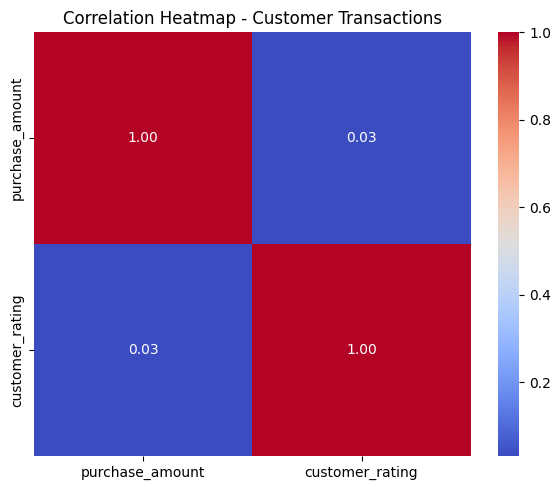

In [38]:
# Correlation heatmap for transactions
plt.figure(figsize=(6, 5))
sns.heatmap(transactions[['purchase_amount', 'customer_rating']].apply(pd.to_numeric, errors='coerce').corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap - Customer Transactions")
plt.tight_layout()
plt.show()

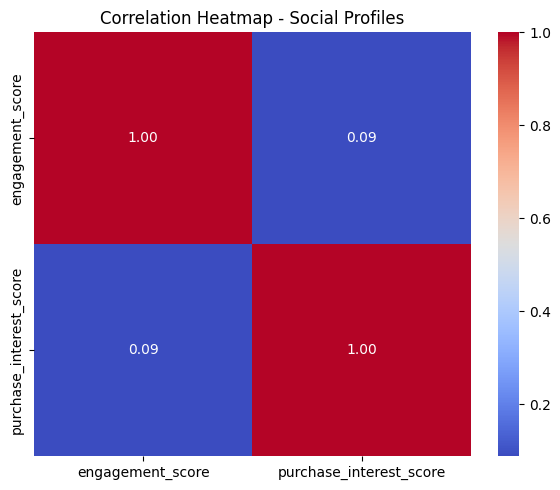

In [39]:
# Correlation heatmap for social profiles
numeric_cols = ['engagement_score', 'purchase_interest_score']
plt.figure(figsize=(6, 5))
sns.heatmap(social_profiles[numeric_cols].apply(pd.to_numeric, errors='coerce').corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap - Social Profiles")
plt.tight_layout()
plt.show()

## Distribution Analysis and Outlier Detection

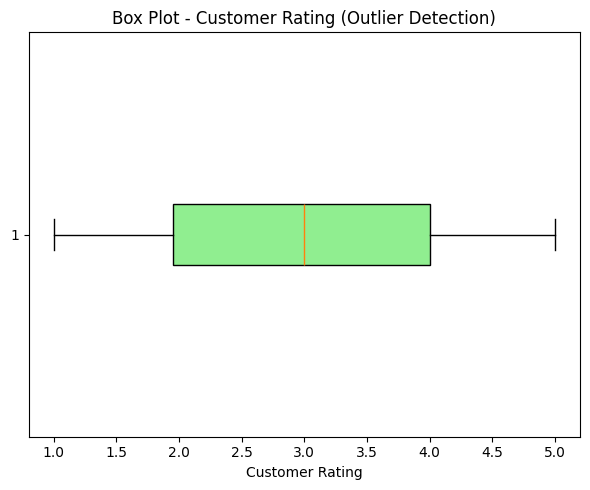

In [40]:
# Box plot for customer rating (outlier detection)
plt.figure(figsize=(6, 5))
plt.boxplot(pd.to_numeric(transactions['customer_rating'], errors='coerce').dropna(), 
            vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title("Box Plot - Customer Rating (Outlier Detection)")
plt.xlabel("Customer Rating")
plt.tight_layout()
plt.show()

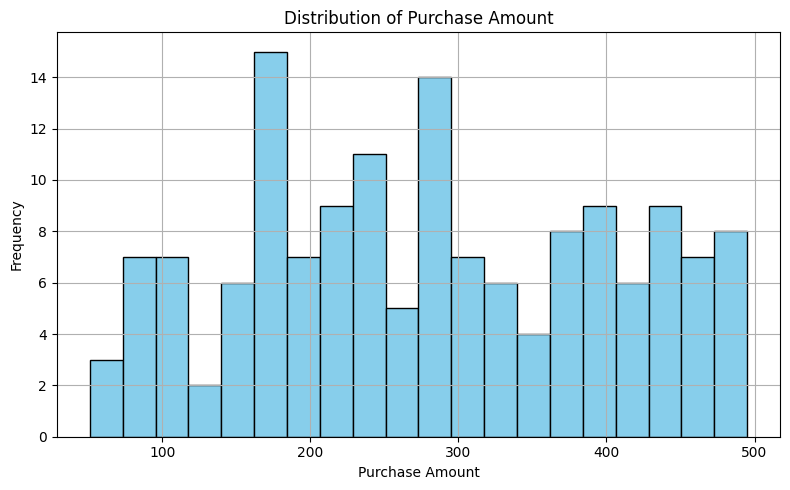

In [41]:
# Distribution of purchase amount
plt.figure(figsize=(8, 5))
plt.hist(pd.to_numeric(transactions['purchase_amount'], errors='coerce').dropna(), 
         bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Purchase Amount")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

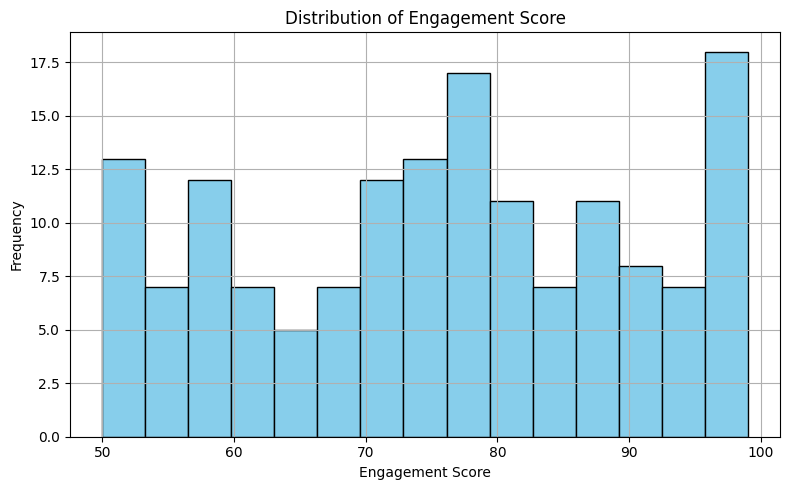

In [42]:
# Distribution of engagement score
plt.figure(figsize=(8, 5))
plt.hist(pd.to_numeric(social_profiles['engagement_score'], errors='coerce').dropna(), 
         bins=15, color='skyblue', edgecolor='black')
plt.title("Distribution of Engagement Score")
plt.xlabel("Engagement Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

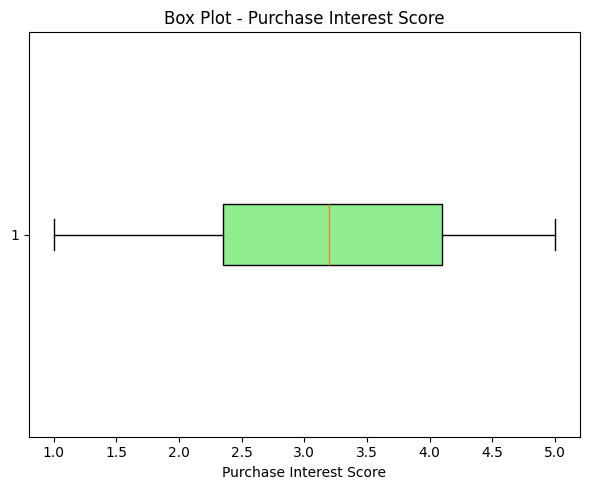

In [43]:
# Box plot for purchase interest score
plt.figure(figsize=(6, 5))
plt.boxplot(pd.to_numeric(social_profiles['purchase_interest_score'], errors='coerce').dropna(), 
            vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title("Box Plot - Purchase Interest Score")
plt.xlabel("Purchase Interest Score")
plt.tight_layout()
plt.show()

In [44]:
# Extract numeric ID from customer_id_new (e.g., A151 → 151)
social_profiles['customer_id_numeric'] = social_profiles['customer_id_new'].str.extract(r'(\d+)').astype(int)

# Rename legacy ID column for consistency
transactions.rename(columns={'customer_id_legacy': 'customer_id_numeric'}, inplace=True)

print("ID Extraction:")
print(social_profiles[['customer_id_new', 'customer_id_numeric']].head())
print("\nTransactions ID column renamed to 'customer_id_numeric'")

ID Extraction:
   customer_id_new  customer_id_numeric
0  A178                             178
1  A190                             190
2  A150                             150
3  A162                             162
4  A197                             197

Transactions ID column renamed to 'customer_id_numeric'


In [45]:
# Merge datasets on customer_id_numeric
merged_data = pd.merge(
    social_profiles,
    transactions,
    on='customer_id_numeric',
    how='inner'
)

print(f"✓ Merged Shape: {merged_data.shape}")
print(f"✓ Columns: {list(merged_data.columns)}")

✓ Merged Shape: (219, 11)
✓ Columns: ['customer_id_new', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment', 'customer_id_numeric', 'transaction_id', 'purchase_amount', 'purchase_date', 'product_category', 'customer_rating']


## Data Quality Checks - Duplicates

In [46]:
# Check and remove duplicates
rows_before = merged_data.shape[0]
merged_data = merged_data.drop_duplicates()
rows_after = merged_data.shape[0]
duplicates_removed = rows_before - rows_after

print(f"Rows before: {rows_before}")
print(f"Rows after: {rows_after}")
print(f"Duplicates removed: {duplicates_removed}")

if duplicates_removed > 0:
    print(f"  Removed {duplicates_removed} duplicate rows")
else:
    print("No duplicates found")

Rows before: 219
Rows after: 213
Duplicates removed: 6
  Removed 6 duplicate rows


## Missing Value Analysis and Imputation

In [47]:
# Check for missing values
print("MISSING VALUES SUMMARY")
missing_values = merged_data.isna().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("✓ No missing values found in the dataset")
else:
    print(f"\nTotal missing values: {missing_values.sum()}")

MISSING VALUES SUMMARY
Series([], dtype: int64)
✓ No missing values found in the dataset


In [48]:
# Analyze customer_rating for imputation strategy
if merged_data['customer_rating'].isna().sum() > 0:
    print("\n" + "=" * 70)
    print("CUSTOMER RATING - MISSING VALUE ANALYSIS")
    print("=" * 70)
    
    # Plot distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(merged_data['customer_rating'], kde=True, bins=20)
    plt.title('Distribution of Customer Rating')
    plt.xlabel('Customer Rating')
    plt.ylabel('Frequency')
    plt.show()
    
    # Calculate skewness
    skewness = merged_data['customer_rating'].skew()
    print(f"\nSkewness: {skewness:.4f}")
    print(merged_data['customer_rating'].describe())
    
    # Determine imputation method based on skewness
    if abs(skewness) < 0.5:
        print("\n✓ Low skewness detected - using MEAN for imputation")
        imputation_method = 'mean'
    else:
        print("\n⚠️  High skewness detected - using MEDIAN for imputation")
        imputation_method = 'median'
else:
    print("\n✓ No missing values in customer_rating column")


✓ No missing values in customer_rating column


In [49]:
# Impute missing values in customer_rating
if merged_data['customer_rating'].isna().sum() > 0:
    missing_before = merged_data['customer_rating'].isna().sum()
    
    if imputation_method == 'mean':
        merged_data['customer_rating'] = merged_data['customer_rating'].fillna(
            merged_data['customer_rating'].mean()
        )
        print(f"✓ Imputed {missing_before} missing values using MEAN")
    else:
        merged_data['customer_rating'] = merged_data['customer_rating'].fillna(
            merged_data['customer_rating'].median()
        )
        print(f"✓ Imputed {missing_before} missing values using MEDIAN")
    
    # Verify imputation
    missing_after = merged_data['customer_rating'].isna().sum()
    print(f"Missing values after imputation: {missing_after}")
else:
    print("No imputation needed for customer_rating")

No imputation needed for customer_rating


In [50]:
# Convert numeric columns to proper types
numeric_cols = ['customer_rating', 'purchase_amount', 'engagement_score', 'purchase_interest_score']
for col in numeric_cols:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

print("Numeric columns converted successfully")
print(f"Missing values after conversion: {merged_data[numeric_cols].isnull().sum().sum()}")

Numeric columns converted successfully
Missing values after conversion: 17


In [51]:
# Aggregate by customer
customer_aggregated = merged_data.groupby('customer_id_new').agg({
    'social_media_platform': 'first',
    'engagement_score': 'first',
    'purchase_interest_score': 'first',
    'review_sentiment': 'first',
    'purchase_amount': ['sum', 'mean', 'count'],
    'customer_rating': 'mean',
    'product_category': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]
}).reset_index()

# Flatten column names
customer_aggregated.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                                for col in customer_aggregated.columns.values]

print(f"Aggregated Shape: {customer_aggregated.shape}")
customer_aggregated.head()

Aggregated Shape: (61, 10)


,customer_id_new,social_media_platform_first,engagement_score_first,purchase_interest_score_first,review_sentiment_first,purchase_amount_sum,purchase_amount_mean,purchase_amount_count,customer_rating_mean,product_category_<lambda>
0,A100,Twitter,73,4.4,Negative,1118,279.500000,4,4.300000,Books
1,A101,Twitter,68,1.0,Neutral,1016,254.000000,4,2.525000,Books
2,A102,LinkedIn,51,4.8,Neutral,569,189.666667,3,3.433333,Electronics
3,A103,Instagram,77,2.3,Positive,2391,265.666667,9,4.200000,Sports
4,A104,Twitter,91,4.6,Negative,2094,349.000000,6,1.450000,Clothing


In [52]:
# Encode categorical variables
le_platform = LabelEncoder()
le_sentiment = LabelEncoder()
le_category = LabelEncoder()

customer_aggregated['platform_encoded'] = le_platform.fit_transform(customer_aggregated['social_media_platform_first'])
customer_aggregated['sentiment_encoded'] = le_sentiment.fit_transform(customer_aggregated['review_sentiment_first'])
customer_aggregated['category_encoded'] = le_category.fit_transform(customer_aggregated['product_category_<lambda>'])

customer_aggregated.head()

,customer_id_new,social_media_platform_first,engagement_score_first,purchase_interest_score_first,review_sentiment_first,purchase_amount_sum,purchase_amount_mean,purchase_amount_count,customer_rating_mean,product_category_<lambda>,platform_encoded,sentiment_encoded,category_encoded
0,A100,Twitter,73,4.4,Negative,1118,279.500000,4,4.300000,Books,4,0,0
1,A101,Twitter,68,1.0,Neutral,1016,254.000000,4,2.525000,Books,4,1,0
2,A102,LinkedIn,51,4.8,Neutral,569,189.666667,3,3.433333,Electronics,2,1,2
3,A103,Instagram,77,2.3,Positive,2391,265.666667,9,4.200000,Sports,1,2,4
4,A104,Twitter,91,4.6,Negative,2094,349.000000,6,1.450000,Clothing,4,0,1


In [53]:
# Save results
customer_aggregated.to_csv('../data/merged_customer_data.csv', index=False)
merged_data.to_csv('../data/merged_customer_data_detailed.csv', index=False)

print("Files saved successfully!")
print(f"Final dataset shape: {customer_aggregated.shape}")
print(f"Columns: {list(customer_aggregated.columns)}")

Files saved successfully!
Final dataset shape: (61, 13)
Columns: ['customer_id_new', 'social_media_platform_first', 'engagement_score_first', 'purchase_interest_score_first', 'review_sentiment_first', 'purchase_amount_sum', 'purchase_amount_mean', 'purchase_amount_count', 'customer_rating_mean', 'product_category_<lambda>', 'platform_encoded', 'sentiment_encoded', 'category_encoded']


## Final Data Quality Validation

In [54]:
# Final validation checks
print("=" * 70)
print("FINAL DATA QUALITY REPORT")
print("=" * 70)

print("\n1. DATASET SHAPE")
print(f"   Aggregated dataset: {customer_aggregated.shape}")
print(f"   Detailed dataset: {merged_data.shape}")

print("\n2. MISSING VALUES CHECK")
missing_agg = customer_aggregated.isna().sum().sum()
missing_detailed = merged_data.isna().sum().sum()
print(f"   Aggregated dataset: {missing_agg} missing values")
print(f"   Detailed dataset: {missing_detailed} missing values")

if missing_agg == 0 and missing_detailed == 0:
    print("   ✓ No missing values detected")
else:
    print("   ⚠️  Missing values still present")

print("\n3. DUPLICATE CHECK")
dup_agg = customer_aggregated.duplicated().sum()
dup_detailed = merged_data.duplicated().sum()
print(f"   Aggregated dataset: {dup_agg} duplicates")
print(f"   Detailed dataset: {dup_detailed} duplicates")

if dup_agg == 0 and dup_detailed == 0:
    print("   ✓ No duplicates detected")
else:
    print("   ⚠️  Duplicates still present")

print("\n4. DATA TYPES")
print("   Numeric columns:", customer_aggregated.select_dtypes(include='number').shape[1])
print("   Object columns:", customer_aggregated.select_dtypes(include='object').shape[1])

print("\n" + "=" * 70)
print("✓ DATA PREPROCESSING COMPLETE")
print("=" * 70)

FINAL DATA QUALITY REPORT

1. DATASET SHAPE
   Aggregated dataset: (61, 13)
   Detailed dataset: (213, 11)

2. MISSING VALUES CHECK
   Aggregated dataset: 4 missing values
   Detailed dataset: 17 missing values
   ⚠️  Missing values still present

3. DUPLICATE CHECK
   Aggregated dataset: 0 duplicates
   Detailed dataset: 0 duplicates
   ✓ No duplicates detected

4. DATA TYPES
   Numeric columns: 9
   Object columns: 4

✓ DATA PREPROCESSING COMPLETE
